# Model a Normal (Gaussian) distribution
Let's start with a simple example. In this example we will be working with the normal (also known as Gaussian) distribution. This is one of the most common distributions. It is continuos, simmetric, and it is defined by two parameters $\mu$ and $\sigma$: 

$$\mathcal{N}(\mu, \sigma)$$ 

$\mu$ is the central tendency of the distribution, while $\sigma$ is a measure of dispersion of the data from the central tendency. 

In this example, we observe some data that look normally distributed. We want to estimate the parameters of the normal distribution that may have generated them. 

Bayesian modelling consists of five steps:
 - data collection
 - model definition
 - model sampling
 - model checking
 - inference

In [17]:
# Load libraries...
# Data processing
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
plt.style.use('seaborn-darkgrid')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st


## 1) Data collection
Here, we will work with fake data. We assume that the data at hand are samples from a normal distribution $\mathcal{N}$, which is defined by the parameters $\mu=0$ and $\sigma=1$: $data\sim\mathcal{N}(0, 1)$. In real world applications, we usually do not know the paramaters in advance, but we want to estimate them given the data. By knowing in advance the values of the parameters we can check if our statistical model is correct.

In [18]:
mu_real = 0
sigma_real = 1

n_samples = 150
SEED = 20191211

np.random.seed(SEED)
Y = np.random.normal(loc=mu_real, scale=sigma_real, size=n_samples)

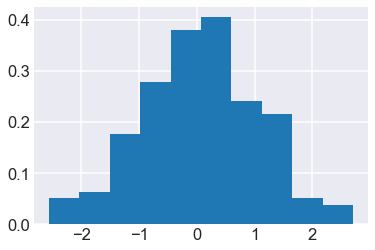

In [19]:
plt.hist(Y, density=True);

## 2) Model definition
Bayesian inference is about modelling the random process that may have generated the data you observed. A bayesian statistical model expresses what we know and what we want to know in terms of probabilities. We build a Bayesian model with a series of probability statements which make the interpretation of the model more intuitive. Remember that the Bayes rule is $p(\theta|y) \propto p(y|\theta) \cdot p(\theta)$. $\theta$ are the unknown in our model. $y$ are the observations we use to learn something from the problem at hand. 

We believe (actaully we know :) ) that the data can be explained by a normal distribution $data\sim\mathcal{N}(\mu, \sigma)$. We can already see that there are three components in this simple model. First, we have the type of distribution from which the data was drawn ($\mathcal{N}$). Then, we see that the normal distribution requires two parameters $\mu, \sigma$. As these are unknown, we slap another probability distribution on them. This is our opportunity to incorporate prior knowledge in our model. It is rare that we know nothing about it. For example, we know that $\mu$ and $\sigma$ are real values. So we shall use a continuos distribution. Moreover, we know that $\sigma$ can take on only positive values

$$data\sim\mathcal{N}(\mu, \sigma)$$

where

$$\mu \sim\mathcal{N}(0, 10)$$
$$\sigma \sim\mathcal{halfN}(0, 10)$$

You will see that in PyMC3 there is a direct translation between the analytical model definition and the code declaration.

In [20]:
with pm.Model() as model:
    
    # Prior
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Likelihood
    observations = pm.Normal('observations', mu=mu, sigma=sigma, observed=Y)

In [21]:
model.check_test_point()

mu               -3.22
sigma_log__      -0.77
observations   -450.58
Name: Log-probability of test_point, dtype: float64

A Bayesian model is a series of probability statements (modules) connected to each others. The following graph highlights the relationship between each module.

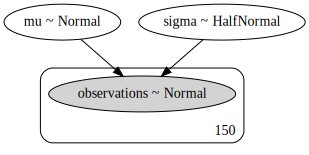

In [22]:
pm.model_to_graphviz(model)

### 3) Model sampling
The model $y\sim\mathcal{N}(\mu, \sigma)$ has been specified and we could, potentially, solve it analytically. This is hard and thus we rely on sampling (Markov Chain Monte Carlo based methods).

In [23]:
with model:
    # Posterior
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=1, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 845.04it/s]


Now the sampling is done, we can explore the results from our model (the posterior probability). We are inspecting the 'trace' which is the series of parameter values the sampler collected while sampling. note that the true parameters we specified in the beginning are close to the bulk of the distribution

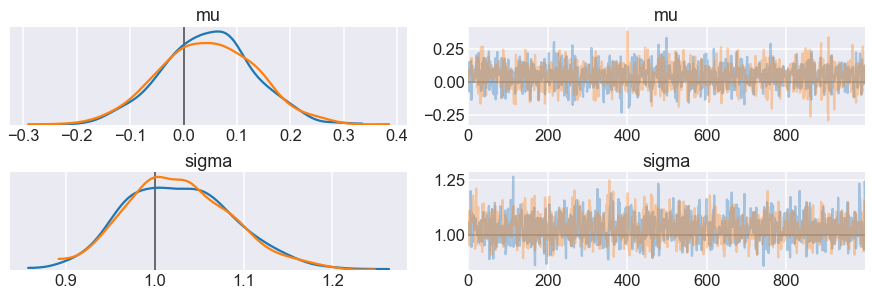

In [24]:
pm.plot_trace(trace, lines=(('mu', {}, mu_real),('sigma', {}, sigma_real)));

We can communicate the results from our statistical analysis by providing a summary for the parameters values we estimated (e.g., mean and standar deviation) **including** uncertainty (95% confidence interval). Everything in our model can be interpreted in terms of probability. The `hpd_2.5%` - `hpd_97.5%` is the credible interval for that parameter. It the range of values the paramter can take with 95% probability.

In [25]:
pm.summary(trace, credible_interval=0.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.046,0.088,-0.139,0.202,0.002,0.002,1797.0,1057.0,1789.0,1266.0,1.01
sigma,1.028,0.061,0.917,1.153,0.001,0.001,1687.0,1676.0,1695.0,1195.0,1.00


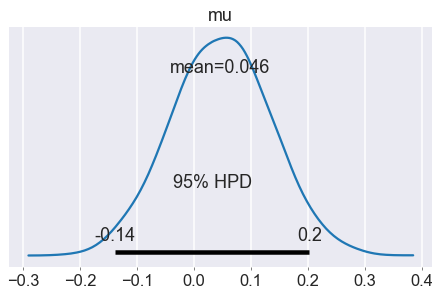

In [26]:
pm.plot_posterior(trace, var_names='mu', credible_interval=0.95);

### 4) Model checking
However, before moving on in our data analysis process we shall check if the model is providing meaningful results. Now that we have an idea of the values for each parameters in our model we can leverage them to generate new, unobserved data and compared them with what we have collected.

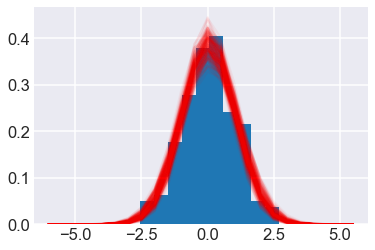

In [27]:
fig, ax = plt.subplots()

THIN = 10
X = np.arange(-6, 6, 0.5)

for mu, sigma in zip(trace['mu'][::THIN], trace['sigma'][::THIN]):
    y = st.norm.pdf(x=X, loc=mu, scale=sigma)
    plt.plot(X, y, alpha=0.05, color='red')

plt.hist(Y, density=True);

We can see that the data we have collected are plausible outcomes of the model we have defined! The lines that are plotted over the histogram of the collected data represents a smattering of normal distributions each defined by a set of parameters $\mu$ and $\sigma$ in the posterior distribution. The larger the band, the higher is our estimation uncertainty

## 5) Inference


In [28]:
with model:
    posterior_samples = pm.sample_posterior_predictive(trace, samples=100)

posterior_samples['observations'].shape

C:\miniconda\envs\intro_to_pymc3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 445.67it/s]


(100, 150)

In [29]:
(posterior_samples['observations'] > 1).mean()

0.1786